In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
import os
from math import floor
import random

# Getting the Data
The csv data contains a png name, whether any condition is known to be present, and which of 14 conditions are present. A patient may have more than one condition.

In [2]:
#get the pre-processed csv data
data_dir = pathlib.Path("./Documents/GitHub/NIH-chest-xrays/")
csvPath = os.path.join(data_dir,"preprocessed_data.csv")

csvData = pd.read_csv(csvPath)
csvData.rename(columns = {'Unnamed: 0':'image_id'}, inplace=True)
label_names = csvData.columns[1:]
csvData.head()

,image_id,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,../input/data/images_001/images/00000001_000.png,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,../input/data/images_001/images/00000001_001.png,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,../input/data/images_001/images/00000001_002.png,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
3,../input/data/images_001/images/00000002_000.png,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,../input/data/images_001/images/00000003_000.png,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


This feature map is used to extract the data from the binary TFRecords.

In [3]:
feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_id': tf.io.FixedLenFeature([], tf.string),
    'No Finding': tf.io.FixedLenFeature([], tf.int64),
    'Atelectasis': tf.io.FixedLenFeature([], tf.int64),
    'Consolidation': tf.io.FixedLenFeature([], tf.int64),
    'Infiltration': tf.io.FixedLenFeature([], tf.int64),
    'Pneumothorax': tf.io.FixedLenFeature([], tf.int64),
    'Edema': tf.io.FixedLenFeature([], tf.int64),
    'Emphysema': tf.io.FixedLenFeature([], tf.int64),
    'Fibrosis': tf.io.FixedLenFeature([], tf.int64),
    'Effusion': tf.io.FixedLenFeature([], tf.int64),
    'Pneumonia': tf.io.FixedLenFeature([], tf.int64),
    'Pleural_Thickening': tf.io.FixedLenFeature([], tf.int64),
    'Cardiomegaly': tf.io.FixedLenFeature([], tf.int64),
    'Nodule': tf.io.FixedLenFeature([], tf.int64),
    'Mass': tf.io.FixedLenFeature([], tf.int64),
    'Hernia': tf.io.FixedLenFeature([], tf.int64)}

In [4]:
#get the paths of the tfrecord files
path = "./Documents/GitHub/NIH-chest-xrays/data/"
files = os.listdir(path)
records = tf.io.gfile.glob([path + filename for filename in files])
records[0:3]

['.\\Documents\\GitHub\\NIH-chest-xrays\\data\\000-438.tfrec',
 '.\\Documents\\GitHub\\NIH-chest-xrays\\data\\001-438.tfrec',
 '.\\Documents\\GitHub\\NIH-chest-xrays\\data\\002-438.tfrec']

In [5]:
# Get one observation, extract image and labels, process image
def image_decoder(data): 
    example = tf.io.parse_single_example(data, feature_map)
    image = example['image']                                 #get image
    image = tf.io.decode_jpeg(image, channels = 3)           #decode        
    image = tf.image.resize_with_pad(image, 150, 150)        #resize
    image = tf.image.convert_image_dtype(image, tf.float32)  #cast to float
    image = image/255.                                       #normalize

    label = []  
    [label.append(example[x]) for x in label_names]          #get labels
    
    return image, label

In [6]:
# Get a batch of observations and map image_decoder onto each of them
def get_ds(filenames): 
    options = tf.data.Options()
    options.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(options)
    dataset = dataset.map(tf.autograph.experimental.do_not_convert(image_decoder))
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(64)
    return dataset

# Train - Validation - Test Split

In [7]:
#Split TFRecords into 80% train, 10% validation, and 10% test sets
# mini is a small subset of train, so I can fiddle with hyperparameters on a reasonable time scale

train = random.sample(records, floor(len(records)*0.8))
val_and_test = list(set(records) - set(train))
valid = random.sample(val_and_test, floor(len(val_and_test)*0.5))
test = list(set(val_and_test) - set(valid))

print("Training size: ", len(train))
print("Validation size: ", len(valid))
print("Test size: ", len(test))

Training size:  204
Validation size:  26
Test size:  26


In [8]:
train_ds = get_ds(train)
valid_ds = get_ds(valid)
test_ds = get_ds(test)

# Looking at the Data

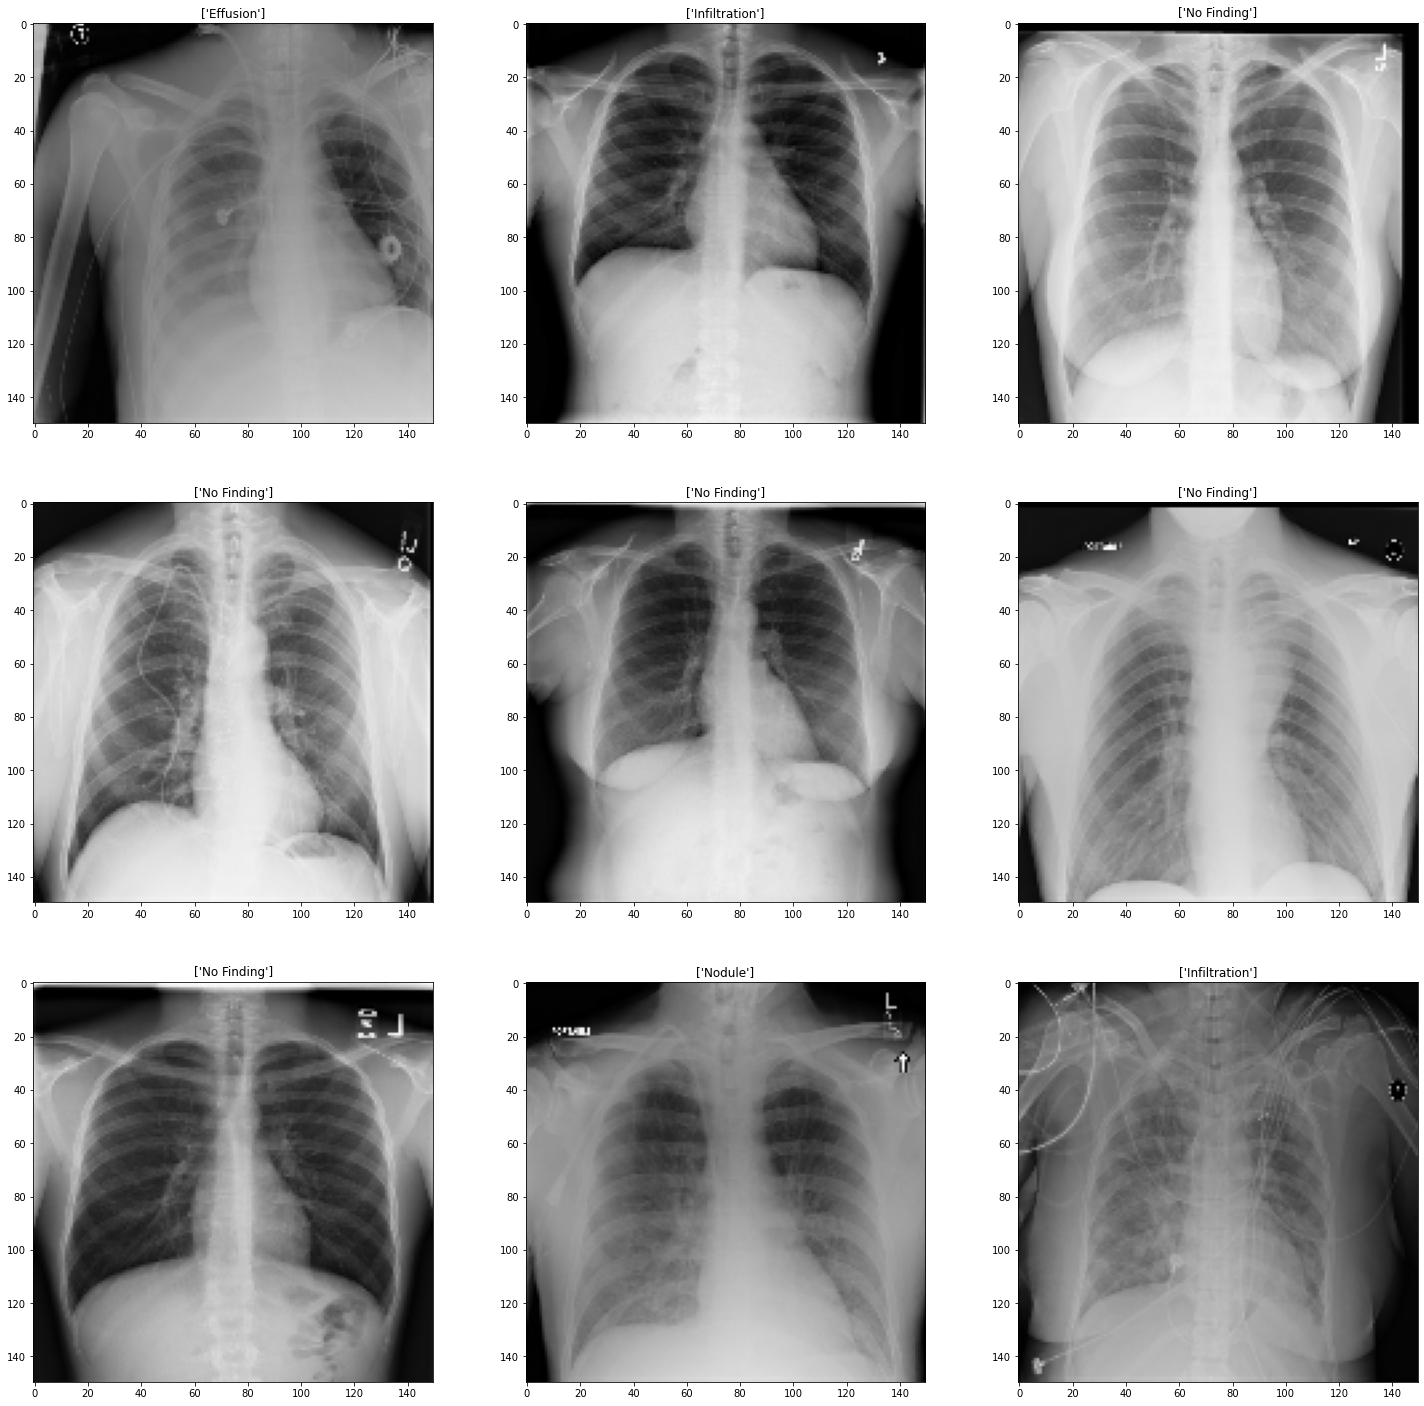

In [11]:
image_show, label_show = next(iter(train_ds))
def plot_observations(images, labels):
    plt.figure(figsize = (25, 25))
    for i in range(9):
        loc = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label = [label_names[j] for j in range(15) if labels[i][j] == 1]
        plt.title(label)
plot_observations(image_show, label_show)

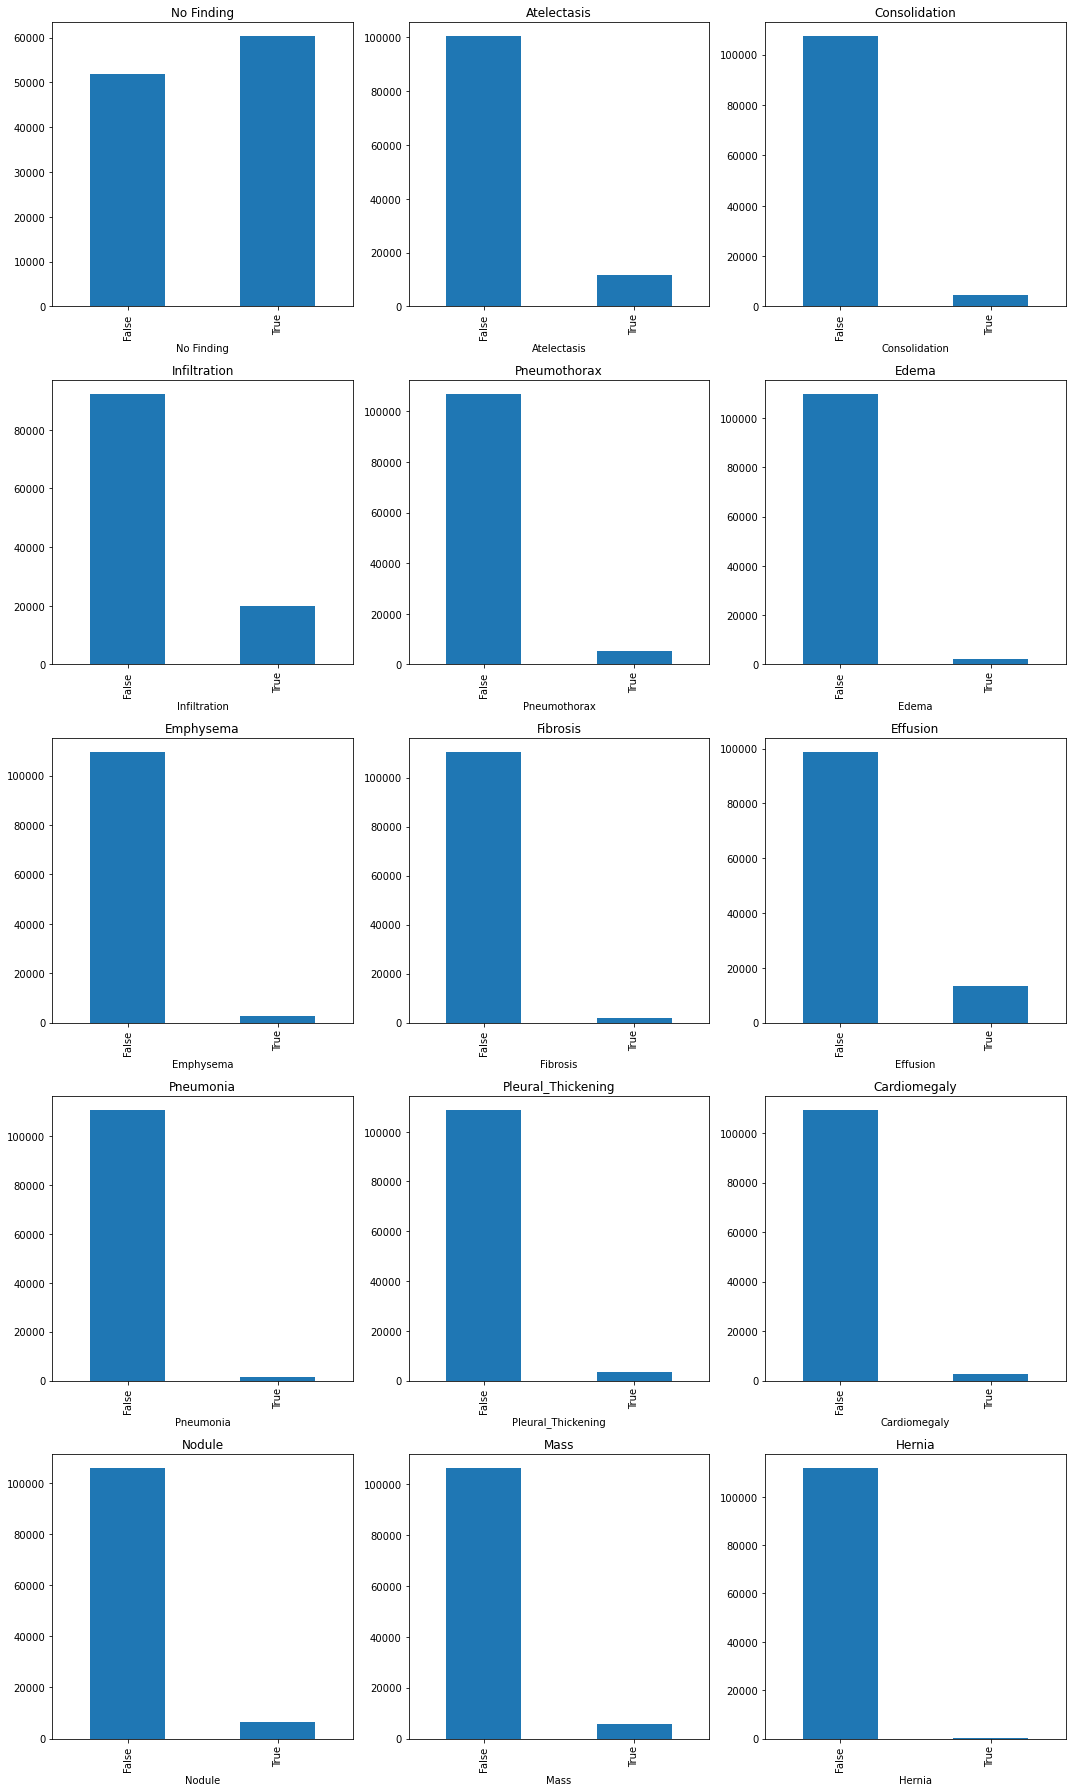

In [31]:
plt.figure(figsize = (15,25), tight_layout=True)
for i in range(1,16):
    plt.subplot(5,3,i).set_title(label_names[i-1])
    Counts = csvData.value_counts(label_names[i-1], sort=False)
    Counts.plot.bar()

# Applying Transfer Learning from InceptionNetV3
Takes InceptionNetV3, removes the last layer, hooks up a flattening layer and a few dense layers.

This is binary multi-label data, so each of the 15 outputs uses a sigmoid activation function to return a value between 0 and 1, and the loss function is binary cross-entropy. 

The metric is ROC-AUC. It measures precision, the proportion of correctly-assigned positives out of all positive assignments, against recall, the proportion of correctly-assigned positives out of all positive labels. The area under that curve (AUC) approaches 1 as predictions get better. Multi-label AUC takes the area under the curve for each label and averages across them.

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image

base_model = InceptionV3(weights = 'imagenet', include_top = False)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1028, activation = 'relu')(x)
predictions = tf.keras.layers.Dense(15, activation = 'sigmoid')(x)

model_IncV3 = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

## Finding the Best Learning Rate

In [13]:
# choose starting and ending learning rates
lr_start = 1e-7
num_epochs = 10
lr_end = 1e-1
denominator = num_epochs / np.log10(lr_end/lr_start)

#create a callback that grows the learning_rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: lr_start * 10**(epoch / denominator))
# shrinks the learning rate
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=100, decay_rate=0.9, staircase=True)

In [15]:
model_IncV3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_start), 
                    loss = 'binary_crossentropy', 
                    metrics = tf.keras.metrics.AUC(multi_label=True))

history = model_IncV3.fit(train_ds, 
                          epochs = num_epochs, 
                          steps_per_epoch = 87, 
                          validation_data = valid_ds, 
                          callbacks = [lr_schedule])

Epoch 1/10
87/87 [==============================] - 732s 8s/step - loss: 0.6987 - auc: 0.4940 - val_loss: 0.7282 - val_auc: 0.4887
Epoch 2/10
87/87 [==============================] - 730s 8s/step - loss: 0.6720 - auc: 0.4966 - val_loss: 0.6219 - val_auc: 0.4728
Epoch 3/10
87/87 [==============================] - 780s 9s/step - loss: 0.5847 - auc: 0.5121 - val_loss: 0.4378 - val_auc: 0.4872
Epoch 4/10
87/87 [==============================] - 801s 9s/step - loss: 0.3940 - auc: 0.5475 - val_loss: 0.2554 - val_auc: 0.4957
Epoch 5/10
87/87 [==============================] - 845s 10s/step - loss: 0.2266 - auc: 0.5807 - val_loss: 0.2297 - val_auc: 0.5657
Epoch 6/10
87/87 [==============================] - 861s 10s/step - loss: 0.2057 - auc: 0.6616 - val_loss: 0.2118 - val_auc: 0.6593
Epoch 7/10
87/87 [==============================] - 805s 9s/step - loss: 0.2035 - auc: 0.6721 - val_loss: 0.2176 - val_auc: 0.6366
Epoch 8/10
87/87 [==============================] - 766s 9s/step - loss: 0.2080 -

(1e-07, 0.1, 0.0, 1.0)

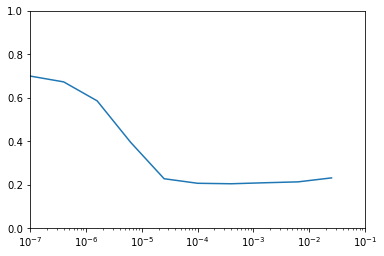

In [16]:
lrs = lr_start * (10 ** (np.arange(num_epochs) / denominator))
plt.semilogx(lrs, history.history["loss"])
plt.axis([lr_start, lr_end, 0, 1]) 


So a good learning rate may be between 10e-4 and 10e-3. The default learning rate for the Adam optimizer is 0.0001, so we're ok just using that.

## Re-Train Some Layers
Freezing all the layers from InceptionNet returned validation AUC ~ 0.69. I tried retraining from layer 1, 123, 155, 165, 187, 219, and 255. Layers 123 and 155 both returned Validation AUC near 0.79. The others did not do so well.

In [ ]:
##Uncomment to see the 310 layers of InceptionNetV3
#for i, layer in enumerate(base_model.layers):
#   print(i, layer.name)

In [ ]:
model_IncV3 = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

for layer in model_IncV3.layers[:133]:
    layer.trainable = False
for layer in model_IncV3.layers[133:]:
    layer.trainable = True
    
model_IncV3.compile(optimizer = tf.keras.optimizers.Adam(), 
                    loss = 'binary_crossentropy', 
                    metrics = tf.keras.metrics.AUC(multi_label=True))

history = model_IncV3.fit(train_ds, epochs = 10, validation_data = valid_ds, steps_per_epoch=128)

# Saving and Loading the Weights

In [ ]:
#model_IncV3.save("inceptionv3-from-layer-155-auc79.h5")

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
model = load_model("inceptionv3-from-layer-155-auc79.h5")


# Confusion Matrices

In [ ]:
label_names

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
#Multi-Label Confusion Matrix applies to one batch
#Specify batch size:
test_size = 5

# Apply new batch size to get_ds()
def get_ds(filenames): 
    options = tf.data.Options()
    options.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(options)
    dataset = dataset.map(image_decoder)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(test_size)
    return dataset

valid_ds = get_ds(valid)

# Generate true and predicted responses
images, labels = next(iter(valid_ds))
def return_ys(labels):
    for i in range(test_size):
        label = labels
        label = tf.cast(label, tf.int32)
        return label
def pred_ys(images):
    for i in range(test_size):
        image = images
        pred = model.predict(image)
        pred = tf.math.round(pred)
        return pred
y_true = return_ys(labels)
y_pred = pred_ys(images)
a = multilabel_confusion_matrix(y_true, y_pred)

# Pretty print confusion matrices
# taken from https://stackoverflow.com/questions/62722416/plot-confusion-matrix-for-multilabel-classifcation-python

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)
    
fig, ax = plt.subplots(3, 5, figsize=(12, 7))
    
    for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
        print_confusion_matrix(a, axes, label_names, ["N", "Y"])
    
    fig.tight_layout()
    plt.show()

In [ ]:
print(history.history.keys())

In [ ]:
auc = history.history["auc_2"]
val_auc = history.history["val_auc_2"]
#loss = history.history[‘loss’]
#val_loss = history.history[‘val_loss’]

epochs = range(len(auc))

plt.plot(epochs, auc)
plt.plot(epochs, val_auc)
plt.title("Training and Validation Accuracy")
plt.figure()


The model does much better than chance, but it must perform far better before we can rely on it as a diagnostic tool. Each diagnosis is represented by only a tiny fraction of the data. I wonder if a mixture-of-experts model, where each neural net is trained on re-balanced data to identify a specific ailment, might be more effective.